In [156]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import numpy as np
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
import matplotlib.pyplot as plt

In [157]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=3600
classification=False
scale=False
max_models=100    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0


In [158]:
#Funtion for meta data
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,
                  balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
 
  return m_data




In [159]:
#Function to convert dictionary into json file
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
    
#Function for random alphabet   
def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str

def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


    

def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val
    return d    

In [160]:
def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id  
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    

In [161]:
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm


def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    

In [162]:
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()     
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

In [163]:

    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [164]:
all_variables=None

In [165]:
data_path='C:/Users/pkash/Downloads/adult.csv'

In [166]:
run_id=alphabet(9)
if server_path==None:
    server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

DTyPnzatz


In [167]:
##For logs
logfile=run_id+'_autoh2o_log.zip'
logs_path=os.path.join(run_dir,'logs')
print(logs_path,' ',logfile)

C:\Users\pkash\DTyPnzatz\logs   DTyPnzatz_autoh2o_log.zip


In [168]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 . connected.


H2O cluster uptime:,5 hours 45 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_pkash_psun55
H2O cluster total nodes:,1
H2O cluster free memory:,1.317 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [169]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555787847.9101012, 'target': None, 'server_path': 'C:\\Users\\pkash', 'data_path': 'C:/Users/pkash/Downloads/adult.csv', 'test_path': None, 'max_models': 100, 'run_time': 3600, 'run_id': 'DTyPnzatz', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555787847.9101012, 'execution_time': 0.0, 'run_path': 'C:\\Users\\pkash\\DTyPnzatz', 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [170]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [171]:
df.head()

age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [172]:

df.describe()
# shows that there is no missing values in the data

Rows:48842
Cols:15




,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
type,int,enum,int,enum,int,enum,enum,enum,enum,enum,int,int,int,enum,enum
mins,17.0,,12285.0,,1.0,,,,,,0.0,0.0,1.0,,
mean,38.643585438761704,,189664.13459727284,,10.078088530363212,,,,,,1079.0676262233324,87.50231358257237,40.42238237582409,,
maxs,90.0,,1490400.0,,16.0,,,,,,99999.0,4356.0,99.0,,
sigma,13.710509934443555,,105604.02542315728,,2.570972755592256,,,,,,7452.019057655393,403.00455212435907,12.391444024252307,,
zeros,0,,0,,0,,,,,,44807,46560,0,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


In [173]:
# split into training and test 
train, test = df.split_frame([0.85])

In [174]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
    target=train.columns[14]   
y = target
y

'income'

In [175]:
test.head()

age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
58,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,<=50K
43,Private,346189,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
20,State-gov,444554,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,25,United-States,<=50K
65,?,191846,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K
39,Private,290208,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Mexico,<=50K
47,Local-gov,171807,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
46,Private,170338,HS-grad,9,Separated,Transport-moving,Not-in-family,White,Male,0,0,40,United-States,<=50K
69,Self-emp-inc,174379,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,30,United-States,<=50K


In [176]:
insignificant = train.columns[11]
insignificant2 = train.columns[12]
insignificant3 = train.columns[3]
x = list(train.columns)
x.remove(y)
x.remove(insignificant)
x.remove(insignificant2)
x.remove(insignificant3)
# Add independent variables

meta_data['x']=x 
# impute missing values

#_=impute_missing_values(df,x, scale)


In [177]:
# # impute missing values

# _ = df[ints].impute(method='median')

# if scale:
    
#     df[ints] = df[ints].scale()

In [178]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [179]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok

In [180]:
ok=check_y(y,df)
if not ok:
    print(ok)

In [181]:
classification=True
if classification:
    print(df[y].levels())

[['<=50K', '>50K']]


In [182]:
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    

In [183]:
allV=get_variables_types(train)
allV

{'age': 'int',
 'workclass': 'enum',
 'fnlwgt': 'int',
 'education': 'enum',
 'educational-num': 'int',
 'marital-status': 'enum',
 'occupation': 'enum',
 'relationship': 'enum',
 'race': 'enum',
 'gender': 'enum',
 'capital-gain': 'int',
 'capital-loss': 'int',
 'hours-per-week': 'int',
 'native-country': 'enum',
 'income': 'enum'}

In [184]:
meta_data['variables']=allV


In [185]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [186]:
model_start_time = time.time()

In [187]:
aml.train(x=x,y=y,training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [258]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [259]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [260]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_151756,0.917525,0.297767,0.178515,0.307924,0.094817
1,GBM_1_AutoML_20190420_151756,0.917278,0.297916,0.180875,0.307963,0.094841
2,GBM_grid_1_AutoML_20190420_151756_model_19,0.916883,0.298844,0.183601,0.308347,0.095078
3,GBM_3_AutoML_20190420_151756,0.916550,0.299240,0.184761,0.308516,0.095182
4,StackedEnsemble_BestOfFamily_AutoML_20190420_151756,0.916435,0.314269,0.180125,0.311898,0.097281
5,GBM_4_AutoML_20190420_151756,0.915630,0.301035,0.182351,0.309700,0.095914
6,GBM_grid_1_AutoML_20190420_151756_model_1,0.915352,0.301663,0.179281,0.309692,0.095909
7,GBM_5_AutoML_20190420_151756,0.915323,0.301448,0.185740,0.309950,0.096069
8,StackedEnsemble_AllModels_AutoML_20190420_151756,0.915290,0.305014,0.179526,0.309747,0.095943
9,GBM_grid_1_AutoML_20190420_151756_model_22,0.914824,0.314859,0.178530,0.313665,0.098386


In [261]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [192]:
mod_best._id


'GBM_2_AutoML_20190420_151756'

In [262]:
#To check the hyperparamter values for best model and saving it 
m= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,m)

In [263]:
# Get stacked ensemble  
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
se=get_stacked_ensemble(model_set)

In [264]:
print(se)

StackedEnsemble_BestOfFamily_AutoML_20190420_151756


In [265]:
if se is not None:
  mod_best=h2o.get_model(se)
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190420_151756'

In [266]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [267]:
#HDP plot for DRF
#mod_best.plot()

In [268]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190420_151756
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08549907043165528
RMSE: 0.2924022408116177
LogLoss: 0.27934653821596483
Null degrees of freedom: 48841
Residual degrees of freedom: 48838
Null deviance: 53750.68147229072
Residual deviance: 27287.687239088307
AIC: 27295.687239088307
AUC: 0.9384553677754798
pr_auc: 0.8048801674799805
Gini: 0.8769107355509596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31683094270409634: 


,<=50K,>50K,Error,Rate
<=50K,33587.0,3568.0,0.096,(3568.0/37155.0)
>50K,2617.0,9070.0,0.2239,(2617.0/11687.0)
Total,36204.0,12638.0,0.1266,(6185.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3168309,0.7457348,239.0
max f2,0.1138782,0.8240087,333.0
max f0point5,0.6416085,0.7744706,128.0
max accuracy,0.4216685,0.8792433,199.0
max precision,0.9638131,1.0,0.0
max recall,0.0389466,1.0,396.0
max specificity,0.9638131,1.0,0.0
max absolute_mcc,0.3168309,0.6624924,239.0
max min_per_class_accuracy,0.2085113,0.8545392,283.0
max mean_per_class_accuracy,0.1613367,0.8581150,305.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.01 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9631953,4.1791734,4.1791734,1.0,0.9637581,1.0,0.9637581,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9618668,4.1791734,4.1791734,1.0,0.9625604,1.0,0.9631599,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9587818,4.1791734,4.1791734,1.0,0.9605773,1.0,0.9622984,0.0418414,0.1254385,317.9173441,317.9173441
,4,0.0400066,0.9475084,4.1791734,4.1791734,1.0,0.9550546,1.0,0.9604893,0.0417558,0.1671943,317.9173441,317.9173441
,5,0.0500184,0.9150892,4.1706271,4.1774628,0.9979550,0.9299592,0.9995907,0.9543783,0.0417558,0.2089501,317.0627074,317.7462768
,6,0.1000164,0.8321726,3.6007293,3.8891551,0.8615889,0.8751252,0.9306039,0.9147599,0.1800291,0.3889792,260.0729287,288.9155059
,7,0.1500143,0.6850344,3.0599353,3.6127862,0.7321867,0.7631624,0.8644739,0.8642343,0.1529905,0.5419697,205.9935345,261.2786212
,8,0.2000123,0.4911239,2.4523978,3.3227188,0.5868141,0.5900630,0.7950660,0.7956985,0.1226149,0.6645846,145.2397846,232.2718816
,9,0.3000082,0.2301420,1.7019607,2.7825030,0.4072482,0.3413103,0.6658022,0.6442461,0.1701891,0.8347737,70.1960682,178.2502975
,10,0.4000041,0.1142400,1.0028647,2.3376162,0.2399672,0.1630480,0.5593489,0.5239527,0.1002824,0.9350560,0.2864716,133.7616183




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09728055910922315
RMSE: 0.31189831533566054
LogLoss: 0.3142686990292805
Null degrees of freedom: 48841
Residual degrees of freedom: 48838
Null deviance: 53753.71062321005
Residual deviance: 30699.023595976236
AIC: 30707.023595976236
AUC: 0.9164346015457667
pr_auc: 0.7805272852960375
Gini: 0.8328692030915334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2794493551359037: 


,<=50K,>50K,Error,Rate
<=50K,32697.0,4458.0,0.12,(4458.0/37155.0)
>50K,2808.0,8879.0,0.2403,(2808.0/11687.0)
Total,35505.0,13337.0,0.1488,(7266.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2794494,0.7096387,249.0
max f2,0.1033773,0.7943161,338.0
max f0point5,0.6603528,0.7399301,120.0
max accuracy,0.4864416,0.8646657,176.0
max precision,0.9647006,1.0,0.0
max recall,0.0369825,1.0,399.0
max specificity,0.9647006,1.0,0.0
max absolute_mcc,0.3407799,0.6142905,225.0
max min_per_class_accuracy,0.1892369,0.8302387,289.0
max mean_per_class_accuracy,0.1743648,0.8314151,296.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 23.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9631653,4.1791734,4.1791734,1.0,0.9641441,1.0,0.9641441,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9610719,4.1791734,4.1791734,1.0,0.9621551,1.0,0.9631506,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9579972,4.1535343,4.1706212,0.9938650,0.9597516,0.9979536,0.9620168,0.0415847,0.1251818,315.3534340,317.0621244
,4,0.0400066,0.9450271,4.1449179,4.1642020,0.9918033,0.9534963,0.9964176,0.9598889,0.0414135,0.1665954,314.4917921,316.4201990
,5,0.0500184,0.9155186,3.8031333,4.0919291,0.9100204,0.9273360,0.9791240,0.9533730,0.0380765,0.2046719,280.3133295,309.1929132
,6,0.1000164,0.8306736,3.4193237,3.7556953,0.8181818,0.8742978,0.8986694,0.9138435,0.1709592,0.3756310,241.9323724,275.5695272
,7,0.1500143,0.6796532,2.8511478,3.4542206,0.6822277,0.7600346,0.8265320,0.8625808,0.1425516,0.5181826,185.1147810,245.4220603
,8,0.2000123,0.4814913,2.3343131,3.1742724,0.5585586,0.5816115,0.7595455,0.7923457,0.1167109,0.6348935,133.4313093,217.4272385
,9,0.3000082,0.2300175,1.6155363,2.6547292,0.3865684,0.3367701,0.6352283,0.6404975,0.1615470,0.7964405,61.5536334,165.4729160
,10,0.4000041,0.1150550,1.0182671,2.2456346,0.2436527,0.1633914,0.5373394,0.5212271,0.1018225,0.8982630,1.8267075,124.5634579



<bound method ModelBase.coef_norm of >


In [269]:
#To check the hyperparamter
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190420_151756',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190420_151756'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult2.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult2.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'income',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_nam

In [270]:
#To check the hyperparamter values for best model and saving it 
g= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,g)

In [271]:

# Get drf best model  
def get_drf_best(lst):
    se=None
    for model in model_set:
      if 'DRF' in model:
        dr=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dr 
dr=get_drf_best(model_set)
print(dr)

DRF_1_AutoML_20190420_151756


In [272]:
if se is not None:
  mod_best_drf=h2o.get_model(dr)
mod_best_drf._id

'DRF_1_AutoML_20190420_151756'

In [273]:
mod_best_drf._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [274]:
type(mod_best_drf)

h2o.estimators.random_forest.H2ORandomForestEstimator

In [275]:
mods_drf=mod_best_drf.coef_norm
print(mods_drf)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190420_151756


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.10179778124717626
RMSE: 0.3190576456491464
LogLoss: 0.36601541039230967
Mean Per-Class Error: 0.18303750253739093
AUC: 0.9027771587708773
pr_auc: 0.6656272597967029
Gini: 0.8055543175417545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37849240058956196: 


,<=50K,>50K,Error,Rate
<=50K,32634.0,4521.0,0.1217,(4521.0/37155.0)
>50K,3150.0,8537.0,0.2695,(3150.0/11687.0)
Total,35784.0,13058.0,0.1571,(7671.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3784924,0.6899980,212.0
max f2,0.1513959,0.7774637,313.0
max f0point5,0.6178665,0.7179575,121.0
max accuracy,0.5192648,0.8558208,157.0
max precision,0.9919063,0.9978006,3.0
max recall,0.0000108,1.0,399.0
max specificity,0.9999835,0.9999193,0.0
max absolute_mcc,0.4125385,0.5881885,197.0
max min_per_class_accuracy,0.2843620,0.8153681,253.0
max mean_per_class_accuracy,0.2555061,0.8169625,265.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0257156,1.0,4.1691913,4.1691913,0.9976115,1.0,0.9976115,1.0,0.1072131,0.1072131,316.9191338,316.9191338
,2,0.0300152,0.9718755,4.1592726,4.1677705,0.9952381,0.9888379,0.9972715,0.9984011,0.0178831,0.1250963,315.9272615,316.7770512
,3,0.0404775,0.9285714,3.9747129,4.1178704,0.9510763,0.9466071,0.9853313,0.9850138,0.0415847,0.1666809,297.4712900,311.7870441
,4,0.0500594,0.8888889,3.7148208,4.0407223,0.8888889,0.9083544,0.9668712,0.9703403,0.0355951,0.2022760,271.4820836,304.0722296
,5,0.1000164,0.7605735,3.2868171,3.6641555,0.7864754,0.8214656,0.8767656,0.8959791,0.1641995,0.3664756,228.6817144,266.4155547
,6,0.1500143,0.6169245,2.7450427,3.3578264,0.6568387,0.6893305,0.8034666,0.8271057,0.1372465,0.5037221,174.5042669,235.7826402
,7,0.2000123,0.4937085,2.2384762,3.0780175,0.5356265,0.5538741,0.7365135,0.7588048,0.1119192,0.6156413,123.8476192,207.8017495
,8,0.3000082,0.3317360,1.5778861,2.5780078,0.3775594,0.4040954,0.6168703,0.6405764,0.1577822,0.7734235,57.7886123,157.8007830
,9,0.4000041,0.2007254,1.0353808,2.1923708,0.2477477,0.2650238,0.5245944,0.5466930,0.1035338,0.8769573,3.5380807,119.2370814
,10,0.5,0.1001164,0.6426206,1.8824335,0.1537674,0.1488593,0.4504320,0.4671295,0.0642594,0.9412167,-35.7379350,88.2433473




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.10060948560452655
RMSE: 0.3171899834555413
LogLoss: 0.3337572586758292
Mean Per-Class Error: 0.1795616457006698
AUC: 0.9055365654486466
pr_auc: 0.7184034740359826
Gini: 0.8110731308972932
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3673705903937419: 


,<=50K,>50K,Error,Rate
<=50K,32447.0,4708.0,0.1267,(4708.0/37155.0)
>50K,2957.0,8730.0,0.253,(2957.0/11687.0)
Total,35404.0,13438.0,0.1569,(7665.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3673706,0.6949254,209.0
max f2,0.1493017,0.7806819,308.0
max f0point5,0.6010641,0.7209159,122.0
max accuracy,0.5131536,0.8563736,152.0
max precision,0.9849858,0.9990548,5.0
max recall,0.0000246,1.0,399.0
max specificity,0.9999540,0.9999731,0.0
max absolute_mcc,0.4093136,0.5940738,190.0
max min_per_class_accuracy,0.2874777,0.8189441,243.0
max mean_per_class_accuracy,0.2725562,0.8204384,250.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0120183,1.0,4.1720539,4.1720539,0.9982964,1.0,0.9982964,1.0,0.0501412,0.0501412,317.2053895,317.2053895
,2,0.0204537,0.99,4.1791734,4.1749901,1.0,0.9961789,0.9989990,0.9984241,0.0352528,0.0853940,317.9173441,317.4990084
,3,0.0300152,0.9609829,4.1433775,4.1649198,0.9914347,0.9774057,0.9965894,0.9917286,0.0396167,0.1250107,314.3377522,316.4919779
,4,0.0400066,0.9226885,4.0335875,4.1321203,0.9651639,0.9445135,0.9887410,0.9799369,0.0403012,0.1653119,303.3587481,313.2120311
,5,0.0500184,0.8876448,3.6663914,4.0388983,0.8773006,0.9050684,0.9664347,0.9649510,0.0367075,0.2020193,266.6391423,303.8898278
,6,0.1000164,0.7547189,3.2978162,3.6684331,0.7891073,0.8171244,0.8777892,0.8910528,0.1648841,0.3669034,229.7816224,266.8433104
,7,0.1500143,0.6154428,2.7604450,3.3658117,0.6605242,0.6838475,0.8053774,0.8219938,0.1380166,0.5049200,176.0445029,236.5811720
,8,0.2000123,0.4905686,2.2299193,3.0818677,0.5335790,0.5523180,0.7374347,0.7545817,0.1114914,0.6164114,122.9919326,208.1867690
,9,0.3000082,0.3289502,1.6223818,2.5954056,0.3882064,0.4031500,0.6210332,0.6374458,0.1622315,0.7786429,62.2381827,159.5405604
,10,0.4000041,0.2017926,1.0174114,2.2009272,0.2434480,0.2635793,0.5266418,0.5439840,0.1017370,0.8803799,1.7411388,120.0927242



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8461569,0.0031708,0.8433821,0.8540281,0.8476659,0.8410115,0.844697
auc,0.9055626,0.0027015,0.903644,0.9117656,0.9071089,0.9002564,0.9050382
err,0.1538431,0.0031708,0.1566179,0.1459719,0.1523342,0.1589885,0.1553030
err_count,1502.8,30.949636,1530.0,1426.0,1488.0,1553.0,1517.0
f0point5,0.6742145,0.0089017,0.6687704,0.6952482,0.6741214,0.6564594,0.6764728
f1,0.696065,0.0048364,0.6969097,0.7052501,0.6940789,0.6845419,0.6995445
f2,0.7195398,0.0037360,0.7275209,0.715544,0.7152542,0.7151346,0.7242454
lift_top_group,4.1747212,0.0411686,4.162335,4.1376534,4.1981735,4.272966,4.102478
logloss,0.3337578,0.0100422,0.3314972,0.3116517,0.3293556,0.3545241,0.3417602
max_per_class_error,0.2638106,0.0065569,0.2505326,0.2774248,0.2698962,0.2629046,0.2582948


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-20 15:18:11,11.795 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-04-20 15:18:11,11.889 sec,1.0,0.3794215,3.0348366,0.8200688,0.3971734,2.6254595,0.1986818
,2019-04-20 15:18:11,11.937 sec,2.0,0.3698587,2.6036993,0.8289474,0.4218464,2.7984218,0.1865569
,2019-04-20 15:18:11,11.992 sec,3.0,0.3648660,2.2467184,0.8355037,0.4410145,2.9262403,0.1976943
,2019-04-20 15:18:11,12.056 sec,4.0,0.3605977,2.0298095,0.8417040,0.4510425,3.0791266,0.1896607
---,---,---,---,---,---,---,---,---,---
,2019-04-20 15:18:15,15.388 sec,23.0,0.3233633,0.4566687,0.8965271,0.6169245,4.1358160,0.1632030
,2019-04-20 15:18:15,15.497 sec,24.0,0.3229004,0.4466181,0.8971118,0.6191734,4.1475130,0.1624626
,2019-04-20 15:18:15,15.575 sec,25.0,0.3225591,0.4336203,0.8976852,0.6219922,4.1544446,0.1625036
,2019-04-20 15:18:15,15.643 sec,26.0,0.3222823,0.4289471,0.8980451,0.6238317,4.1541634,0.1622374



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
marital-status,36036.9296875,1.0,0.1640119
relationship,35221.1718750,0.9773633,0.1602992
capital-gain,35070.9804688,0.9731956,0.1596157
educational-num,26357.1484375,0.7313927,0.1199571
occupation,25825.8535156,0.7166497,0.1175391
age,23130.9101562,0.6418668,0.1052738
fnlwgt,17421.0488281,0.4834221,0.0792870
workclass,7922.6894531,0.2198492,0.0360579
native-country,7186.5512695,0.1994219,0.0327076
race,3030.2910156,0.0840885,0.0137915


<bound method ModelBase.coef_norm of >


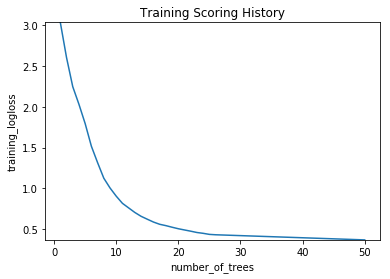

In [276]:
#HDP plot for DRF
mod_best_drf.plot()

In [277]:
#Hyperparamaters for DRF
mod_best_drf.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190420_151756',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190420_151756'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult2.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult2.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [278]:
#To check the hyperparamter values for best model and saving it 
r= run_id+'_mod_best_drf.params.json'
dict_to_json(mod_best_drf.params,r)

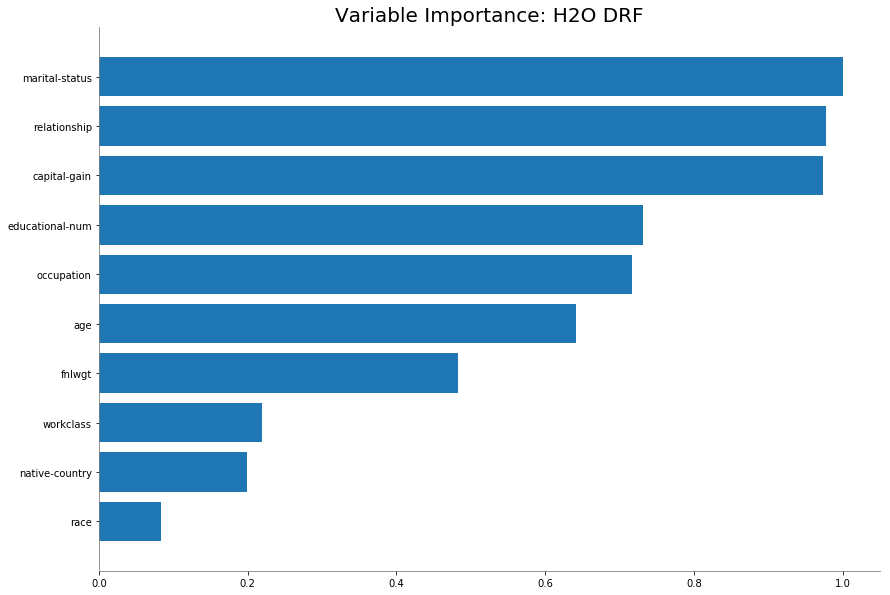

In [279]:
%matplotlib inline
mod_best_drf.varimp_plot()

In [280]:
# Get glm best model  
def get_glm_best(lst):
    se=None
    for model in model_set:
      if 'GLM' in model:
        dl=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dl 
dl=get_glm_best(model_set)
print(dl)

GLM_grid_1_AutoML_20190420_151756_model_1


In [281]:
if se is not None:
  mod_best_glm=h2o.get_model(dl)
mod_best_glm._id

'GLM_grid_1_AutoML_20190420_151756_model_1'

In [282]:
mod_best_glm.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190420_151756_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190420_151756_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult2.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult2.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 7025913962425331448},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [283]:
#To check the hyperparamter values for GLM best model and saving it 
o= run_id+'_mod_best_glm.params.json'
dict_to_json(mod_best_glm.params,o)

In [284]:
# Get XRT best model  
def get_xrt_best(lst):
    xr=None
    for model in model_set:
      if 'XRT' in model:
        xr=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return xr 
xr=get_xrt_best(model_set)
print(xr)

XRT_1_AutoML_20190420_151756


In [285]:
if se is not None:
  mod_best_xrt=h2o.get_model(xr)
mod_best_xrt._id

'XRT_1_AutoML_20190420_151756'

In [286]:
mod_best_xrt.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XRT_1_AutoML_20190420_151756',
   'type': 'Key<Model>',
   'URL': '/3/Models/XRT_1_AutoML_20190420_151756'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult2.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult2.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [287]:
#To check the hyperparamter values for XRT best model and saving it 
k= run_id+'_mod_best_xrt.params.json'
dict_to_json(mod_best_xrt.params,k)

In [288]:
# Get DeepLearning best model  
def get_dl_best(lst):
    xr=None
    for model in model_set:
      if 'DeepLearning' in model:
        dl=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dl 
dl=get_dl_best(model_set)
print(dl)

DeepLearning_grid_1_AutoML_20190420_151756_model_13


In [289]:
if se is not None:
  mod_best_dl=h2o.get_model(dl)
mod_best_dl._id

'DeepLearning_grid_1_AutoML_20190420_151756_model_13'

In [290]:
mod_best_dl.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DeepLearning_grid_1_AutoML_20190420_151756_model_13',
   'type': 'Key<Model>',
   'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190420_151756_model_13'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult2.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult2.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_column': {'default': None, 'actual':

In [291]:
#To check the hyperparamter values for Deep Learning best model and saving it 
l= run_id+'_mod_best_dl.params.json'
dict_to_json(mod_best_dl.params,l)

In [292]:
bm=stackedensemble_df(aml_leaderboard_df)

In [293]:
bm

['GBM_2_AutoML_20190420_151756',
 'GLM_grid_1_AutoML_20190420_151756_model_1',
 'DRF_1_AutoML_20190420_151756',
 'XRT_1_AutoML_20190420_151756',
 'DeepLearning_grid_1_AutoML_20190420_151756_model_3']

In [294]:

aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_151756,0.917525,0.297767,0.178515,0.307924,0.094817
1,GBM_1_AutoML_20190420_151756,0.917278,0.297916,0.180875,0.307963,0.094841
2,GBM_grid_1_AutoML_20190420_151756_model_19,0.916883,0.298844,0.183601,0.308347,0.095078
3,GBM_3_AutoML_20190420_151756,0.916550,0.299240,0.184761,0.308516,0.095182
4,StackedEnsemble_BestOfFamily_AutoML_20190420_151756,0.916435,0.314269,0.180125,0.311898,0.097281
5,GBM_4_AutoML_20190420_151756,0.915630,0.301035,0.182351,0.309700,0.095914
6,GBM_grid_1_AutoML_20190420_151756_model_1,0.915352,0.301663,0.179281,0.309692,0.095909
7,GBM_5_AutoML_20190420_151756,0.915323,0.301448,0.185740,0.309950,0.096069
8,StackedEnsemble_AllModels_AutoML_20190420_151756,0.915290,0.305014,0.179526,0.309747,0.095943
9,GBM_grid_1_AutoML_20190420_151756_model_22,0.914824,0.314859,0.178530,0.313665,0.098386


In [295]:
#  Get best_models and coef_norm() of Leader board for GBM
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [296]:

bm

['GBM_2_AutoML_20190420_151756',
 'DeepLearning_grid_1_AutoML_20190420_151756_model_3',
 'XRT_1_AutoML_20190420_151756',
 'DRF_1_AutoML_20190420_151756',
 'GLM_grid_1_AutoML_20190420_151756_model_1',
 'StackedEnsemble_BestOfFamily_AutoML_20190420_151756']

In [297]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [298]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_151756,0.917525,0.297767,0.178515,0.307924,0.094817
4,StackedEnsemble_BestOfFamily_AutoML_20190420_151756,0.916435,0.314269,0.180125,0.311898,0.097281
28,DeepLearning_grid_1_AutoML_20190420_151756_model_3,0.907721,0.319666,0.185324,0.317748,0.100964
29,XRT_1_AutoML_20190420_151756,0.907473,0.314089,0.195340,0.315792,0.099725
33,DRF_1_AutoML_20190420_151756,0.905537,0.333757,0.189864,0.317190,0.100609
44,GLM_grid_1_AutoML_20190420_151756_model_1,0.899784,0.328367,0.191948,0.324150,0.105073


In [299]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [300]:
#To check the hyperparamter values for best model and saving it 
r= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,r)

In [301]:
#This will show the model details, model summary and significant variables of Stacked ensemble
mod_best.set_params()

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190420_151756
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08549907043165528
RMSE: 0.2924022408116177
LogLoss: 0.27934653821596483
Null degrees of freedom: 48841
Residual degrees of freedom: 48838
Null deviance: 53750.68147229072
Residual deviance: 27287.687239088307
AIC: 27295.687239088307
AUC: 0.9384553677754798
pr_auc: 0.8048801674799805
Gini: 0.8769107355509596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31683094270409634: 


,<=50K,>50K,Error,Rate
<=50K,33587.0,3568.0,0.096,(3568.0/37155.0)
>50K,2617.0,9070.0,0.2239,(2617.0/11687.0)
Total,36204.0,12638.0,0.1266,(6185.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3168309,0.7457348,239.0
max f2,0.1138782,0.8240087,333.0
max f0point5,0.6416085,0.7744706,128.0
max accuracy,0.4216685,0.8792433,199.0
max precision,0.9638131,1.0,0.0
max recall,0.0389466,1.0,396.0
max specificity,0.9638131,1.0,0.0
max absolute_mcc,0.3168309,0.6624924,239.0
max min_per_class_accuracy,0.2085113,0.8545392,283.0
max mean_per_class_accuracy,0.1613367,0.8581150,305.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.01 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9631953,4.1791734,4.1791734,1.0,0.9637581,1.0,0.9637581,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9618668,4.1791734,4.1791734,1.0,0.9625604,1.0,0.9631599,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9587818,4.1791734,4.1791734,1.0,0.9605773,1.0,0.9622984,0.0418414,0.1254385,317.9173441,317.9173441
,4,0.0400066,0.9475084,4.1791734,4.1791734,1.0,0.9550546,1.0,0.9604893,0.0417558,0.1671943,317.9173441,317.9173441
,5,0.0500184,0.9150892,4.1706271,4.1774628,0.9979550,0.9299592,0.9995907,0.9543783,0.0417558,0.2089501,317.0627074,317.7462768
,6,0.1000164,0.8321726,3.6007293,3.8891551,0.8615889,0.8751252,0.9306039,0.9147599,0.1800291,0.3889792,260.0729287,288.9155059
,7,0.1500143,0.6850344,3.0599353,3.6127862,0.7321867,0.7631624,0.8644739,0.8642343,0.1529905,0.5419697,205.9935345,261.2786212
,8,0.2000123,0.4911239,2.4523978,3.3227188,0.5868141,0.5900630,0.7950660,0.7956985,0.1226149,0.6645846,145.2397846,232.2718816
,9,0.3000082,0.2301420,1.7019607,2.7825030,0.4072482,0.3413103,0.6658022,0.6442461,0.1701891,0.8347737,70.1960682,178.2502975
,10,0.4000041,0.1142400,1.0028647,2.3376162,0.2399672,0.1630480,0.5593489,0.5239527,0.1002824,0.9350560,0.2864716,133.7616183




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09728055910922315
RMSE: 0.31189831533566054
LogLoss: 0.3142686990292805
Null degrees of freedom: 48841
Residual degrees of freedom: 48838
Null deviance: 53753.71062321005
Residual deviance: 30699.023595976236
AIC: 30707.023595976236
AUC: 0.9164346015457667
pr_auc: 0.7805272852960375
Gini: 0.8328692030915334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2794493551359037: 


,<=50K,>50K,Error,Rate
<=50K,32697.0,4458.0,0.12,(4458.0/37155.0)
>50K,2808.0,8879.0,0.2403,(2808.0/11687.0)
Total,35505.0,13337.0,0.1488,(7266.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2794494,0.7096387,249.0
max f2,0.1033773,0.7943161,338.0
max f0point5,0.6603528,0.7399301,120.0
max accuracy,0.4864416,0.8646657,176.0
max precision,0.9647006,1.0,0.0
max recall,0.0369825,1.0,399.0
max specificity,0.9647006,1.0,0.0
max absolute_mcc,0.3407799,0.6142905,225.0
max min_per_class_accuracy,0.1892369,0.8302387,289.0
max mean_per_class_accuracy,0.1743648,0.8314151,296.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 23.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9631653,4.1791734,4.1791734,1.0,0.9641441,1.0,0.9641441,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9610719,4.1791734,4.1791734,1.0,0.9621551,1.0,0.9631506,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9579972,4.1535343,4.1706212,0.9938650,0.9597516,0.9979536,0.9620168,0.0415847,0.1251818,315.3534340,317.0621244
,4,0.0400066,0.9450271,4.1449179,4.1642020,0.9918033,0.9534963,0.9964176,0.9598889,0.0414135,0.1665954,314.4917921,316.4201990
,5,0.0500184,0.9155186,3.8031333,4.0919291,0.9100204,0.9273360,0.9791240,0.9533730,0.0380765,0.2046719,280.3133295,309.1929132
,6,0.1000164,0.8306736,3.4193237,3.7556953,0.8181818,0.8742978,0.8986694,0.9138435,0.1709592,0.3756310,241.9323724,275.5695272
,7,0.1500143,0.6796532,2.8511478,3.4542206,0.6822277,0.7600346,0.8265320,0.8625808,0.1425516,0.5181826,185.1147810,245.4220603
,8,0.2000123,0.4814913,2.3343131,3.1742724,0.5585586,0.5816115,0.7595455,0.7923457,0.1167109,0.6348935,133.4313093,217.4272385
,9,0.3000082,0.2300175,1.6155363,2.6547292,0.3865684,0.3367701,0.6352283,0.6404975,0.1615470,0.7964405,61.5536334,165.4729160
,10,0.4000041,0.1150550,1.0182671,2.2456346,0.2436527,0.1633914,0.5373394,0.5212271,0.1018225,0.8982630,1.8267075,124.5634579


In [302]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GBM_2_AutoML_20190420_151756


In [303]:
mod_best_lead=h2o.get_model(top)
print(mod_best_lead._id)
print(mod_best_lead.algo)

GBM_2_AutoML_20190420_151756
gbm


In [304]:
#To check the hyperparamter values for best model and saving it 
j= run_id+'_mod_best_lead.params.json'
dict_to_json(mod_best_lead.params,j)

In [305]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo
meta_data['mod_best.params'] = mod_best.params
meta_data['mod_best.varimp()'] = mod_best.varimp()


In [306]:
#Variable Imp for GBM
mod_best_lead.varimp()

[('relationship', 7178.64404296875, 1.0, 0.3258112881784224),
 ('capital-gain', 4266.6083984375, 0.5943473966530636, 0.19364509092902643),
 ('educational-num',
  3352.874267578125,
  0.46706233760986615,
  0.15217418187629572),
 ('marital-status',
  2270.415283203125,
  0.31627355662340206,
  0.10304549490024185),
 ('occupation', 2154.69189453125, 0.3001530486306395, 0.09779325142502933),
 ('age', 1254.8729248046875, 0.17480640038612794, 0.05695389849163742),
 ('native-country',
  649.7994995117188,
  0.09051841763183346,
  0.029491922252500084),
 ('workclass', 467.8385314941406, 0.06517087749355303, 0.021233407547892668),
 ('fnlwgt', 248.80584716796875, 0.03465917040581864, 0.011292348957115225),
 ('gender', 106.62307739257812, 0.01485281576219286, 0.004839215036556832),
 ('race', 81.96106719970703, 0.011417346606004967, 0.003719900405282017)]

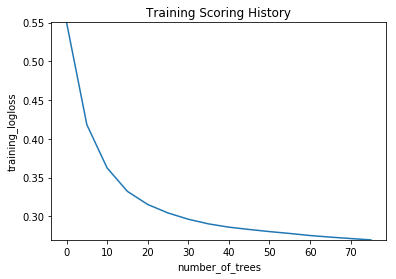

In [307]:
#Plot to see the hyper parameter dependency plot
import matplotlib.pyplot as plt
mod_best_lead.plot()

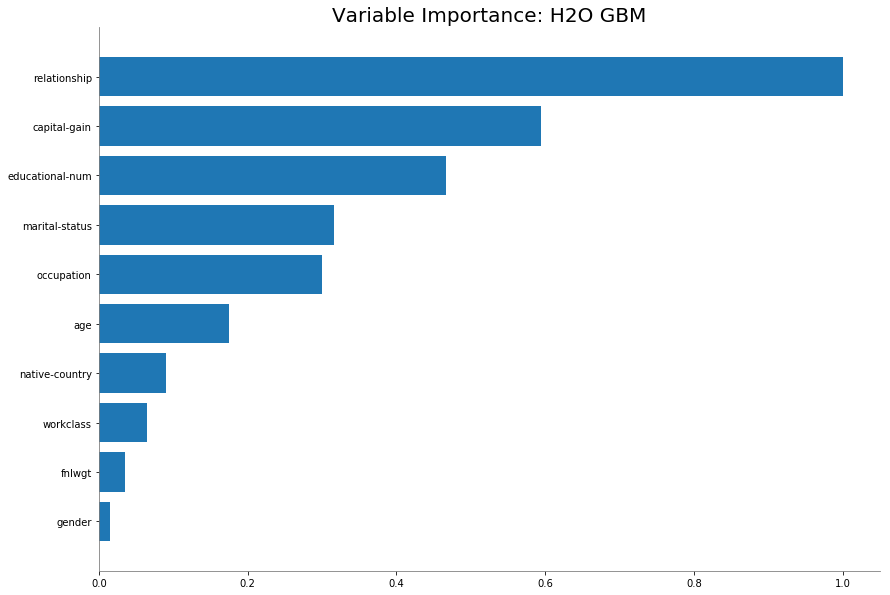

In [308]:
%matplotlib inline
mod_best_lead.varimp_plot()

In [309]:
meta_data['models']=bm

In [310]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass

In [311]:
print(models_path)

C:\Users\pkash\DTyPnzatz\models


In [312]:
# GBM
 
# mod,mod_id=get_model_by_algo("GBM",best_models)
# if mod is not None:
#     try:     
#         sh_df=mod.scoring_history()
#         sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
#     except:
#         pass   
#     try:     
#         stats_gbm={}
#         stats_gbm=gbm_stats(mod)
#         n=run_id+'_gbm_stats.json'
#         dict_to_json(stats_gbm,n)
#         print(stats_gbm)
#     except:
#         pass

In [313]:
# if mod is not None:
#     try:    
#         sh_df=mod.scoring_history()
#         sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
#     except:
#         pass 
#     try:
#         stats_dl={}
#         stats_dl=dl_stats(mod)
#         n=run_id+'_dl_stats.json'
#         dict_to_json(stats_dl,n)
#         print(stats_dl)
#     except:
#         pass    
#     try:
#         cf=mod.confusion_matrix()    
#         cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
#     except:
#         pass

In [314]:
# # DRF

# mod,mod_id=get_model_by_algo("DRF",best_models)
# if mod is not None:
#     try:     
#          sh_df=mod.scoring_history()
#          sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
#     except:
#          pass  
#     try: 
#          stats_drf={}
#          stats_drf=drf_stats(mod)
#          n=run_id+'_drf_stats.json'
#          dict_to_json(stats_drf,n)
#          print(stats_drf)
#     except:
#          pass

In [315]:
# stats_xrt

In [316]:
# XRT

# mod,mod_id=get_model_by_algo("XRT",best_models)
# if mod is not None:
#     try:     
#          sh_df=mod.scoring_history()
#          sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
#     except:
#          pass     
#     try:        
#          stats_xrt={}
#          stats_xrt=xrt_stats(mod)
#          n=run_id+'_xrt_stats.json'
#          dict_to_json(stats_xrt,n)
#          print(stats_xrt)
#     except:
#          pass

In [317]:
# GLM

# mod,mod_id=get_model_by_algo("GLM",best_models)
# if mod is not None:
#     try:     
#          stats_glm={}
#          stats_glm=glm_stats(mod)
#          n=run_id+'_glm_stats.json'
#          dict_to_json(stats_glm,n)
#          print(stats_glm)
#     except:
#          pass

In [318]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions
predictions_df=predictions_test(mod_best,test,run_id)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [319]:

predictions_df.head()

predict,<=50K,>50K
>50K,0.0426123,0.957388
<=50K,0.96223,0.0377703
<=50K,0.873489,0.126511
>50K,0.0824349,0.917565
<=50K,0.961871,0.0381287
<=50K,0.887512,0.112488
<=50K,0.950286,0.0497136
<=50K,0.955798,0.0442017
<=50K,0.94524,0.0547601
<=50K,0.781765,0.218235


In [320]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [321]:
meta_data

{'start_time': 1555787847.9101012,
 'target': None,
 'server_path': 'C:\\Users\\pkash',
 'data_path': 'C:/Users/pkash/Downloads/adult.csv',
 'test_path': None,
 'max_models': 100,
 'run_time': 3600,
 'run_id': 'DTyPnzatz',
 'scale': False,
 'classification': False,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1555791124.203867,
 'execution_time': 3276.29376578331,
 'run_path': 'C:\\Users\\pkash\\DTyPnzatz',
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'x': ['age',
  'workclass',
  'fnlwgt',
  'educational-num',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'capital-gain',
  'native-country'],
 'variables': {'age': 'int',
  'workclass': 'enum',
  'fnlwgt': 'int',
  'education': 'enum',
  'educational-num': 'int',
  'marital-status': 'enum',
  'occupation': 'enum',
  'relationship': 'enum',
  'race': 'enum',
  'gender': 'enum',
  'capital-gain': 'int',
  'capital-loss': 'int',
  'hours-per-week':

In [322]:
# Save logs
h2o.download_all_logs(dirname=logs_path, filename=logfile)

Writing H2O logs to C:\Users\pkash\DTyPnzatz\logs\DTyPnzatz_autoh2o_log.zip


'C:\\Users\\pkash\\DTyPnzatz\\logs\\DTyPnzatz_autoh2o_log.zip'

In [323]:
# Clean up
os.chdir(server_path)

In [324]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    print(stats_test)   
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
      print(cf)   
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      print(cf_df)    
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

In [325]:
# -------------------------------------------------------------
#Grid Search on GBM using hyperparameters from automl run
#--------------------------------------------------------------

gbm_params = {'learn_rate': 0.1,
                'max_depth': 15,
                'sample_rate': 0.8,
                'col_sample_rate': 0.8,
                'max_abs_leafnode_pred' : 1.7976931348623157e+308,
                 'balance_classes' : False,
                 'distribution' : "bernoulli",
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': 7326776092369443733, 'stopping_rounds' : 0 , "max_runtime_secs":0,
                  "stopping_metric": 'logloss', "stopping_tolerance": 0.004524840555912091}


               

In [327]:


# Train and validate a cartesian grid of GBMs
gbm_grid_3 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid_3',
                           
                          hyper_params=gbm_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
gbm_grid_3.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               
               ntrees = 65)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Get the grid results, sorted by validation AUC
# gbm_gridperf = gbm_grid.get_grid(sort_by=None, decreasing=None)
# gbm_gridperf



In [ ]:
# Grab the top GBM model, chosen by validation AUC
# best_gbm2 = gbm_gridperf2.models[0]
# best_gbm2

In [328]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm3= gbm_grid_3.model_performance(test)

best_gbm3


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.10364704642714956
RMSE: 0.3219426135620284
LogLoss: 0.3253560545973948
Mean Per-Class Error: 0.1780061308123746
AUC: 0.9035747489528979
pr_auc: 0.7395600932482327
Gini: 0.8071494979057958
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3329012341451168: 


,<=50K,>50K,Error,Rate
<=50K,4831.0,739.0,0.1327,(739.0/5570.0)
>50K,443.0,1266.0,0.2592,(443.0/1709.0)
Total,5274.0,2005.0,0.1624,(1182.0/7279.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3329012,0.6817447,221.0
max f2,0.0961034,0.7791173,323.0
max f0point5,0.5942005,0.7024044,130.0
max accuracy,0.5360509,0.8532765,148.0
max precision,0.9967062,1.0,0.0
max recall,0.0021764,1.0,396.0
max specificity,0.9967062,1.0,0.0
max absolute_mcc,0.4260777,0.5808019,186.0
max min_per_class_accuracy,0.2335680,0.8166966,262.0
max mean_per_class_accuracy,0.2074287,0.8219939,272.0


Gains/Lift Table: Avg response rate: 23.48 %, avg score: 23.04 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100289,0.9958425,4.2592159,4.2592159,1.0,0.9964484,1.0,0.9964484,0.0427150,0.0427150,325.9215916,325.9215916
,2,0.0200577,0.9950187,4.2592159,4.2592159,1.0,0.9954444,1.0,0.9959464,0.0427150,0.0854301,325.9215916,325.9215916
,3,0.0300866,0.9932896,4.2592159,4.2592159,1.0,0.9944019,1.0,0.9954316,0.0427150,0.1281451,325.9215916,325.9215916
,4,0.0401154,0.9811228,4.2592159,4.2592159,1.0,0.9893185,1.0,0.9939033,0.0427150,0.1708602,325.9215916,325.9215916
,5,0.0500069,0.9245410,3.7859697,4.1656068,0.8888889,0.9467805,0.9780220,0.9845823,0.0374488,0.2083090,278.5969703,316.5606775
,6,0.1000137,0.7950187,3.1125039,3.6390554,0.7307692,0.8560719,0.8543956,0.9203271,0.1556466,0.3639555,211.2503938,263.9055357
,7,0.1500206,0.6494650,2.6912628,3.3231245,0.6318681,0.7226859,0.7802198,0.8544467,0.1345816,0.4985372,169.1262804,232.3124506
,8,0.2000275,0.4943538,2.1998148,3.0422971,0.5164835,0.5725461,0.7142857,0.7839716,0.1100059,0.6085430,119.9814814,204.2297083
,9,0.3000412,0.2906273,1.6323094,2.5723012,0.3832418,0.3833217,0.6039377,0.6504216,0.1632534,0.7717964,63.2309396,157.2301187
,10,0.4000550,0.1382078,1.1174591,2.2085907,0.2623626,0.2082227,0.5185440,0.5398719,0.1117613,0.8835576,11.7459121,120.8590671


{'gbm_grid_3_model_1': }

In [330]:
#Checking the auc

gbm_grid_3.auc()

{'gbm_grid_3_model_1': 0.9827776212939957}

In [331]:
#HDP plot for GBM
# import matplotlib.pyplot as plt
# gbm_grid_2.plot()

In [332]:
#VIMP plot for GBM
# import matplotlib.pyplot as plt
# best_gbm2.varimp_plot()

In [333]:
# -------------------------------------------------------------
#Grid Search on DRF using hyperparameters from automl run
#--------------------------------------------------------------

drf_params = {'mtries': -1,
                'categorical_encoding':"Auto",
                'distribution' : "multinomial",
                'sample_rate' : 0.6320000290870667,
                'max_depth': 20
                
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': -5019446138132085552, 'stopping_rounds' : 0 , "max_runtime_secs":0,
                  "stopping_metric": 'logloss', "stopping_tolerance": 0.004524840555912091}



In [334]:
# Train and validate a cartesian grid of DRFs
drf_grid_3 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='drf_grid_3',
                          hyper_params=drf_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
drf_grid_3.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               ntrees = 50)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [335]:
# Grab the top DRF model

best_perf_3_drf = drf_grid_2.model_performance()

best_perf_3_drf 


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1022860646656311
RMSE: 0.3198219264929018
LogLoss: 0.38311640739717956
Mean Per-Class Error: 0.18468622867465467
AUC: 0.9011856926029775
pr_auc: 0.6613132736420453
Gini: 0.8023713852059551
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3718709093396854: 


,<=50K,>50K,Error,Rate
<=50K,27600.0,3987.0,0.1262,(3987.0/31587.0)
>50K,2618.0,7292.0,0.2642,(2618.0/9910.0)
Total,30218.0,11279.0,0.1592,(6605.0/41497.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3718709,0.6882817,212.0
max f2,0.1639198,0.7750195,304.0
max f0point5,0.5840914,0.7191054,131.0
max accuracy,0.5467491,0.8556040,144.0
max precision,0.9847893,0.9974160,3.0
max recall,0.0000113,1.0,399.0
max specificity,0.9999975,0.9999050,0.0
max absolute_mcc,0.4121708,0.5856634,194.0
max min_per_class_accuracy,0.2857937,0.8143857,249.0
max mean_per_class_accuracy,0.2703882,0.8153138,256.0


Gains/Lift Table: Avg response rate: 23.88 %, avg score: 24.21 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0262188,1.0,4.1758404,4.1758404,0.9972426,1.0,0.9972426,1.0,0.1094854,0.1094854,317.5840376,317.5840376
,2,0.0300022,0.9601400,4.1340440,4.1705697,0.9872611,0.9804951,0.9959839,0.9975403,0.0156408,0.1251261,313.4043975,317.0569665
,3,0.0400029,0.9281422,3.9048640,4.1041433,0.9325301,0.9434892,0.9801205,0.9840276,0.0390515,0.1641776,290.4864017,310.4143253
,4,0.0500036,0.8888889,3.6021614,4.0037469,0.8602410,0.9062308,0.9561446,0.9684682,0.0360242,0.2002018,260.2161380,300.3746879
,5,0.1000072,0.7609624,3.3398191,3.6717830,0.7975904,0.8197710,0.8768675,0.8941196,0.1670030,0.3672048,233.9819095,267.1782987
,6,0.1500108,0.6126064,2.6980895,3.3472185,0.6443373,0.6861064,0.7993574,0.8247819,0.1349142,0.5021191,169.8089504,234.7218493
,7,0.2000145,0.4906791,2.2319274,3.0683957,0.5330120,0.5504460,0.7327711,0.7561979,0.1116044,0.6137235,123.1927443,206.8395730
,8,0.2999976,0.3332456,1.6037014,2.5802427,0.3829839,0.4045323,0.6161941,0.6389949,0.1603431,0.7740666,60.3701401,158.0242724
,9,0.4000048,0.2041576,1.0221259,2.1906901,0.2440964,0.2663737,0.5231640,0.5458340,0.1022200,0.8762866,2.2125904,119.0690052
,10,0.5000120,0.1043478,0.6033873,1.8732142,0.1440964,0.1516568,0.4473469,0.4669948,0.0603431,0.9366297,-39.6612744,87.3214193


{'drf_grid_2_model_1': }

In [336]:
#Grab the auc of the model

drf_grid_3.auc()



{'drf_grid_3_model_1': 0.9037958592011497}

In [337]:
# -------------------------------------------------------------
#Grid Search on GLM using hyperparameters from automl run
#--------------------------------------------------------------

glm_params = {'tweedie_variance_power': 0,
                'tweedie_link_power':1.0,
                'theta' : 1e-10,
                'missing_values_handling': "MeanImputation",
                
                
                'alpha' : [0.0,0.2,0.4,0.6,0.8,1.0],
                'lambda' : [14.190629444115807,8.812621300901148,5.472787130334066,3.398693527303556,2.110646260752699,1.3107470862675006,
                            0.813996147107118,0.5055053979879761,0.3139274163681697,0.19495424408887968,0.1210698884728571,0.07518645189456613,
                            0.04669206042724046,0.028996560577140867,0.018007355374989435,0.011182872766530513,0.006944753447033205,
                            0.004312809547867441,0.0026783277963773667,0.0016632869374894371,0.0010329293674078712,0.0006414666369376214,
                            0.00039836164919646624,0.0002473893331508685,0.00015363296712994504,9.540867542076526e-05,
                            5.9250403839728236e-05,3.679550459838807e-05,2.2850631741047847e-05,1.4190629444115783e-05]
                
        
              
        
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': -4125445981862322467}



In [338]:
# Train and validate a cartesian grid of GLM
glm_grid_3 = H2OGridSearch(model=H2OGeneralizedLinearEstimator,
                          grid_id='glm_grid_3',
                          hyper_params=glm_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
glm_grid_3.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               )

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [1.4190629444115783e-05]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentE


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [0.19495424408887968]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [0.07518645189456613]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.jav


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [9.540867542076526e-05]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [2.110646260752699]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [0.813996147107118]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [5.472787130334066]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [0.006944753447033205]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.ja


Hyper-parameter: alpha, [0.8]
Hyper-parameter: lambda, [14.190629444115807]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.0006414666369376214]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [1.3107470862675006]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.5055053979879761]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java


Hyper-parameter: alpha, [0.8]
Hyper-parameter: lambda, [0.00039836164919646624]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.


Hyper-parameter: alpha, [0.8]
Hyper-parameter: lambda, [0.1210698884728571]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.004312809547867441]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.ja


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [3.679550459838807e-05]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.5055053979879761]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.3139274163681697]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.0010329293674078712]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.04669206042724046]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_3_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_3_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.jav

ValueError: Illegal argument(s) for GLM model: glm_grid_3_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_2.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_3.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_4.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_5.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_7.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_8.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_9.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_10.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_12.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_13.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_14.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_15.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_17.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_18.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_19.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_20.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_22.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_23.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_24.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_25.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_27.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_28.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_29.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_30.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_32.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_33.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_34.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_35.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_37.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_38.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_39.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_40.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_42.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_43.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_44.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_45.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_47.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_48.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_49.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_50.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_52.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_53.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_54.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_55.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_57.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_58.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_59.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_60.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_62.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_63.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_64.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_65.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_67.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_68.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_69.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_70.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_72.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_73.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_74.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_75.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_77.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_78.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_79.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_80.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_82.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_83.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_84.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_85.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_87.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_88.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_89.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_90.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_92.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_93.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_94.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_95.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_97.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_98.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_99.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_3_model_100.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2



In [339]:
# -------------------------------------------------------------
#Grid Search on Deep Learning using hyperparameters from automl run
#--------------------------------------------------------------

glm_params = {'epochs': 10.400347062469448,
                'activation':"Rectifier",
                'hidden' : [10,10,10],
                'rho': 0.99,
                'epsilon': 1e-08,
                'rate' : 0.005,
                'rate_annealing':1e-06,
                'rate_decay':1.0,
                "adaptive_rate" :True,
                "l1":0.0,
                'l2':0.0,
                'max_w2':3.4028235e+38,
                'initial_weight_distribution':"UniformAdaptive",
                "initial_weight_scale": "1.0",
                "distribution":"AUTO",
                "quantile_alpha": 0.5,
                "tweedie_power" :1.5,
                "huber_alpha" : 0.9,
                "score_interval" :0.5,
                "score_training_samples" : 10000,
                "score_duty_cycle" :0.1,
                
                "elastic_averaging_regularization": 0.001,
                "elastic_averaging_moving_rate":0.9
                 }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': 7554291713383186588}

In [340]:
# Train and validate a cartesian grid of Deeplearning
dl_grid_1 = H2OGridSearch(model= H2ODeepLearningEstimator,
                          grid_id='dl_grid_1',
                          hyper_params=glm_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
dl_grid_1.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               )

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [341]:
# Grab the top DRF model

dl_grid_pref_1 = dl_grid_1.model_performance()

dl_grid_pref_1 


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.10105930555781756
RMSE: 0.3178982629046871
LogLoss: 0.3163806500674385
Mean Per-Class Error: 0.173833799450411
AUC: 0.9084027157954103
pr_auc: 0.7387347112317446
Gini: 0.8168054315908206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31053313869024973: 


,<=50K,>50K,Error,Rate
<=50K,6581.0,1041.0,0.1366,(1041.0/7622.0)
>50K,549.0,1862.0,0.2277,(549.0/2411.0)
Total,7130.0,2903.0,0.1585,(1590.0/10033.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3105331,0.7007904,229.0
max f2,0.1395195,0.7893421,304.0
max f0point5,0.6248755,0.7124234,112.0
max accuracy,0.4361241,0.8535832,178.0
max precision,0.9294023,0.9969697,21.0
max recall,0.0002906,1.0,399.0
max specificity,0.9998666,0.9998688,0.0
max absolute_mcc,0.3105331,0.5990009,229.0
max min_per_class_accuracy,0.2538470,0.8241394,252.0
max mean_per_class_accuracy,0.2256552,0.8261662,264.0


Gains/Lift Table: Avg response rate: 24.03 %, avg score: 22.44 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100668,0.9991832,4.1201424,4.1201424,0.9900990,0.9998007,0.9900990,0.9998007,0.0414766,0.0414766,312.0142417,312.0142417
,2,0.0200339,0.9916304,4.1613438,4.1406406,1.0,0.9975361,0.9950249,0.9986740,0.0414766,0.0829531,316.1343841,314.0640638
,3,0.0300010,0.9434424,4.1613438,4.1475188,1.0,0.9672040,0.9966777,0.9882189,0.0414766,0.1244297,316.1343841,314.7518778
,4,0.0400678,0.8733987,3.8317324,4.0681794,0.9207921,0.9105551,0.9776119,0.9687063,0.0385732,0.1630029,283.1732447,306.8179426
,5,0.0500349,0.8305046,3.4955288,3.9541056,0.84,0.8489188,0.9501992,0.9448443,0.0348403,0.1978432,249.5528826,295.4105602
,6,0.1000698,0.6943165,3.2660746,3.6100901,0.7848606,0.7605424,0.8675299,0.8526933,0.1634177,0.3612609,226.6074648,261.0090125
,7,0.1500050,0.5733625,2.6911685,3.3041900,0.6467066,0.6359912,0.7940199,0.7805553,0.1343841,0.4956450,169.1168472,230.4189960
,8,0.2000399,0.4603089,2.2713311,3.0458466,0.5458167,0.5156651,0.7319382,0.7142997,0.1136458,0.6092908,127.1331100,204.5846588
,9,0.3000100,0.2939680,1.7674302,2.6198494,0.4247258,0.3687629,0.6295681,0.5991591,0.1766902,0.7859809,76.7430186,161.9849362
,10,0.3999801,0.1713073,1.0496710,2.2274026,0.2522433,0.2299509,0.5352604,0.5068800,0.1049357,0.8909166,4.9670979,122.7402584




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.10002033535409362
RMSE: 0.3162599174003775
LogLoss: 0.31594303088142744
Mean Per-Class Error: 0.17770145105426938
AUC: 0.9093881129358552
pr_auc: 0.7276745372486537
Gini: 0.8187762258717104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3474033791249863: 


,<=50K,>50K,Error,Rate
<=50K,6615.0,992.0,0.1304,(992.0/7607.0)
>50K,590.0,1836.0,0.2432,(590.0/2426.0)
Total,7205.0,2828.0,0.1577,(1582.0/10033.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3474034,0.6988961,217.0
max f2,0.1424306,0.7879371,302.0
max f0point5,0.5755774,0.7336896,132.0
max accuracy,0.5244588,0.8592644,150.0
max precision,0.9857349,0.9915966,5.0
max recall,0.0010701,1.0,397.0
max specificity,0.9997828,0.9997371,0.0
max absolute_mcc,0.4518398,0.6006000,177.0
max min_per_class_accuracy,0.2619475,0.8197713,253.0
max mean_per_class_accuracy,0.2211984,0.8222985,269.0


Gains/Lift Table: Avg response rate: 24.18 %, avg score: 23.49 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100668,0.9995314,4.0537208,4.0537208,0.9801980,0.9999263,0.9801980,0.9999263,0.0408079,0.0408079,305.3720830,305.3720830
,2,0.0200339,0.9981385,4.1356142,4.0944638,1.0,0.9991007,0.9900498,0.9995156,0.0412201,0.0820280,313.5614180,309.4463790
,3,0.0300010,0.9508191,4.0942580,4.0943954,0.99,0.9759822,0.9900332,0.9916972,0.0408079,0.1228359,309.4258038,309.4395434
,4,0.0400678,0.8948719,3.8080408,4.0224506,0.9207921,0.9240806,0.9726368,0.9747089,0.0383347,0.1611707,280.8040779,302.2450608
,5,0.0500349,0.8633074,3.7634089,3.9708487,0.91,0.8780833,0.9601594,0.9554608,0.0375103,0.1986810,276.3408904,297.0848675
,6,0.1000698,0.7265183,3.2541187,3.6124837,0.7868526,0.7916064,0.8735060,0.8735336,0.1628195,0.3615004,225.4118727,261.2483701
,7,0.1500050,0.6064006,2.9139158,3.3799372,0.7045908,0.6690656,0.8172757,0.8054682,0.1455070,0.5070074,191.3915779,237.9937170
,8,0.2000399,0.4870049,2.2737640,3.1032561,0.5498008,0.5457071,0.7503737,0.7404956,0.1137675,0.6207749,127.3763971,210.3256081
,9,0.3000100,0.3132408,1.5833259,2.5967810,0.3828514,0.3978907,0.6279070,0.6263319,0.1582852,0.7790602,58.3325867,159.6780997
,10,0.3999801,0.1770367,1.0349344,2.2064166,0.2502493,0.2411352,0.5335161,0.5300567,0.1034625,0.8825227,3.4934356,120.6416636




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.10185000477842542
RMSE: 0.3191394754310808
LogLoss: 0.3206819408616868
Mean Per-Class Error: 0.1750769404135457
AUC: 0.9076131860587799
pr_auc: 0.7294164791100917
Gini: 0.8152263721175599
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30546880549754163: 


,<=50K,>50K,Error,Rate
<=50K,6483.0,1115.0,0.1467,(1115.0/7598.0)
>50K,536.0,1898.0,0.2202,(536.0/2434.0)
Total,7019.0,3013.0,0.1646,(1651.0/10032.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3054688,0.6968974,228.0
max f2,0.1217209,0.7910075,313.0
max f0point5,0.5538519,0.7177190,137.0
max accuracy,0.4335405,0.8548644,179.0
max precision,0.9980304,0.9854015,1.0
max recall,0.0002590,1.0,399.0
max specificity,0.9996775,0.9997368,0.0
max absolute_mcc,0.4298364,0.5949658,180.0
max min_per_class_accuracy,0.2653523,0.8208710,246.0
max mean_per_class_accuracy,0.2224899,0.8249231,264.0


Gains/Lift Table: Avg response rate: 24.26 %, avg score: 23.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100678,0.9987869,4.0399945,4.0399945,0.9801980,0.9997000,0.9801980,0.9997000,0.0406738,0.0406738,303.9994468,303.9994468
,2,0.0200359,0.9827979,4.0391783,4.0395884,0.98,0.9941454,0.9800995,0.9969365,0.0402629,0.0809367,303.9178307,303.9588418
,3,0.0300040,0.9453186,4.0391783,4.0394522,0.98,0.9666401,0.9800664,0.9868713,0.0402629,0.1211997,303.9178307,303.9452168
,4,0.0400718,0.8833251,3.6727222,3.9473136,0.8910891,0.9122057,0.9577114,0.9681120,0.0369762,0.1581758,267.2722243,294.7313555
,5,0.0500399,0.8519713,3.3797206,3.8342472,0.82,0.8683033,0.9302789,0.9482298,0.0336894,0.1918652,237.9720624,283.4247235
,6,0.1000797,0.7244166,3.3087829,3.5715151,0.8027888,0.7862194,0.8665339,0.8672246,0.1655711,0.3574363,230.8782945,257.1515090
,7,0.1500199,0.6022979,2.7559671,3.3000270,0.6686627,0.6646277,0.8006645,0.7997821,0.1376335,0.4950698,175.5967113,230.0027026
,8,0.2000598,0.4778122,2.2742751,3.0434613,0.5517928,0.5371698,0.7384155,0.7340963,0.1138044,0.6088743,127.4275126,204.3461279
,9,0.3000399,0.3047342,1.7053523,2.5975731,0.4137587,0.3822236,0.6302326,0.6168443,0.1705012,0.7793755,70.5352308,159.7573140
,10,0.4000199,0.1838775,1.0766321,2.2174326,0.2612164,0.2434378,0.5380015,0.5235160,0.1076417,0.8870173,7.6632059,121.7432621


{'dl_grid_1_model_3': , 'dl_grid_1_model_2': , 'dl_grid_1_model_1': }

In [342]:
# Grab the auc For DL model

dl_grid_1.auc()

{'dl_grid_1_model_3': 0.9084027157954103,
 'dl_grid_1_model_2': 0.9093881129358552,
 'dl_grid_1_model_1': 0.9076131860587799}

In [ ]:
# h2o.cluster().shutdown()